# Support Vector Machines

A *Support Vector Machine* is a powerful and versatile Machine Learning model that is capable of performing linear and nonlinear classification, regression, and even outlier detection. SVMs are particularly well suited for classification of complex small- or medium-sized datasets.

## Linear SVM Classification

The fundamental idea behind support vector machines is to fit the widest possible street between each class. This is called *large margin classification* (see below). 

When a straight line that clearly separates classes can be drawn, we say that the classes are *linearly separable*.

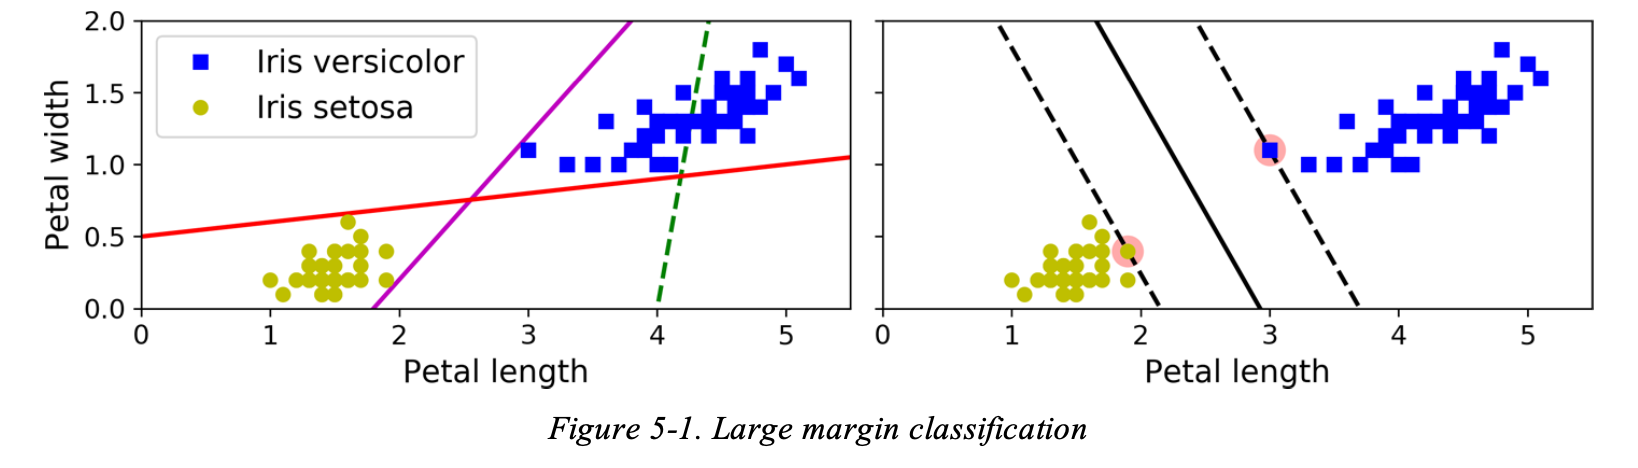

The decision boundary is defined by the straight solid line, and the margin by the two dotted lines. The instances highlighted in red on the right are called *support vectors*. A support vector is a data instance that determines the edges of the decision boundary. In this case there are two.

Further, SVMs are sensitive to feature scales:

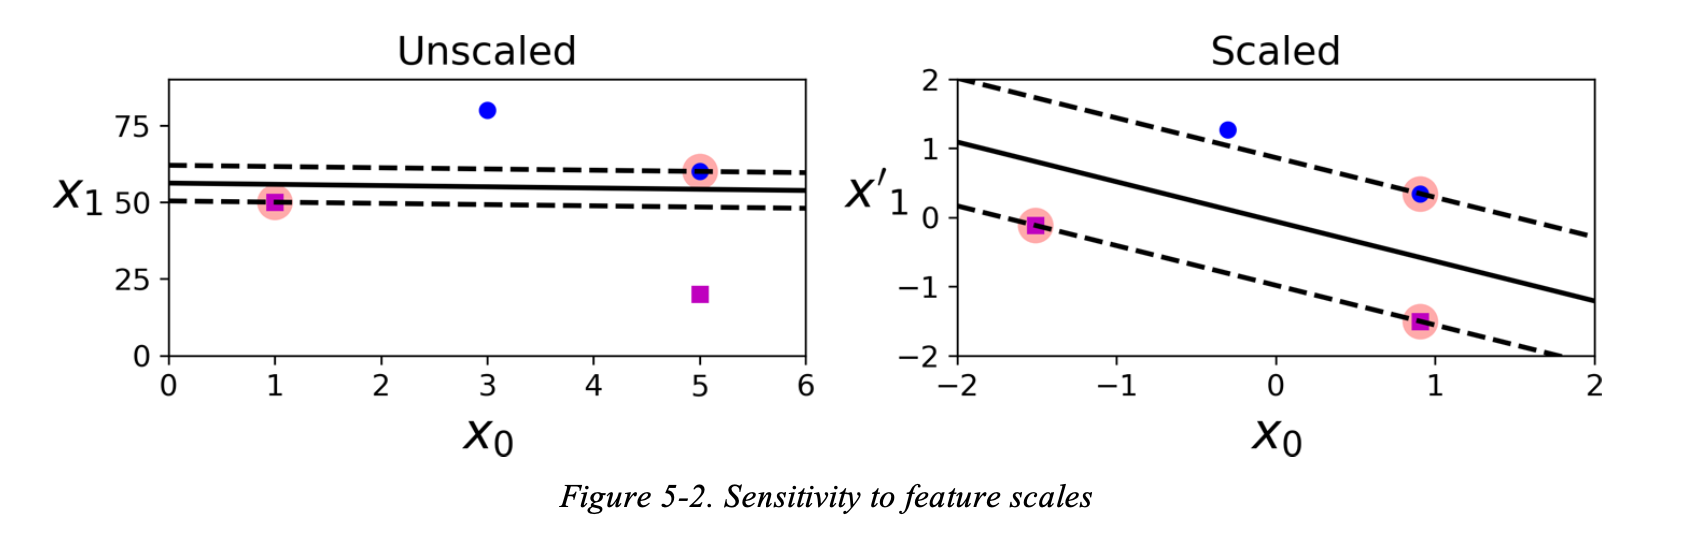

As such, it is important to always scale the input features with `StandardScaler` or similar class before using the data to train the model.

### Soft Margin Classification

When we strictly impose that there can be no instances within the margin, we are performing *hard margin classification*. This only works if the data is linearly separable, and is sensitive to outliers in the data. For example: consider if we add an outlier to the data shown in the figures above:

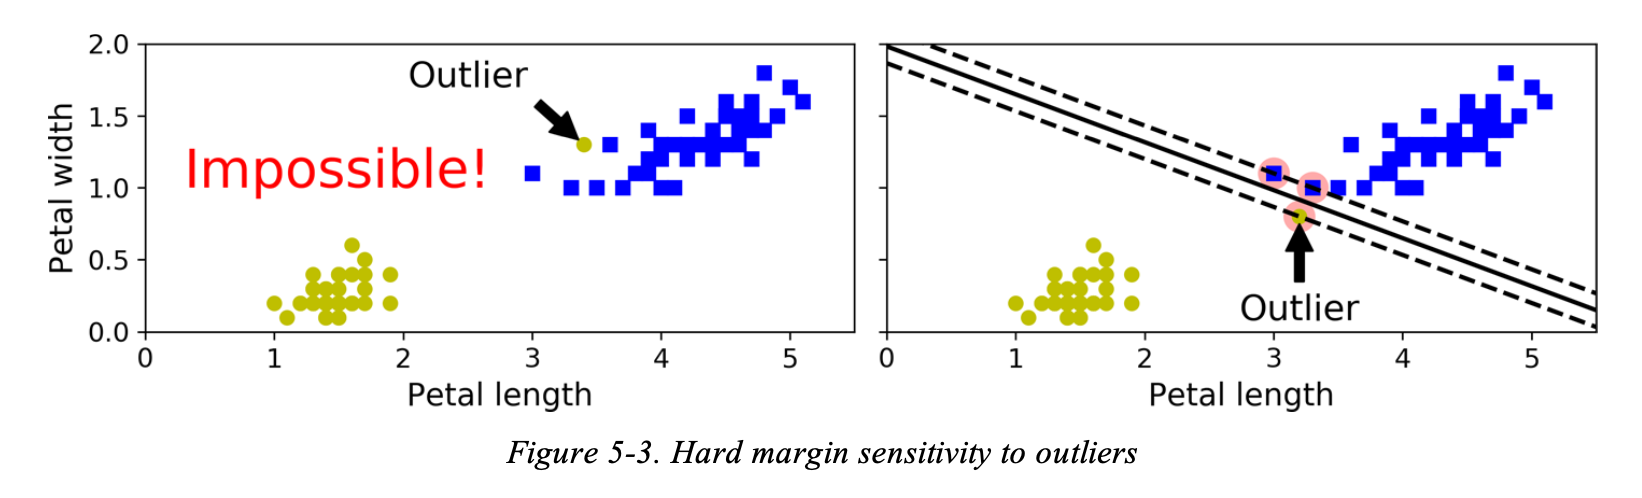

Notice that one outlier makes it impossible to draw a linear decision boundary between the classes (left) and another makes the margins on the decision boundary very thin, which means that the model would probably not generalize very well.

To avoid these issues, we can use a more flexible model: *soft margin classification*. This model type allows for some *margin violations*. 

There are a number of hyperparameters in Scikit-Learn's SVM model. One of the most important is `C`. Knowing how to best tweak the hyperparameters of the SVM, or any machine learning model for that matter, can make or break your model. The `C` parameter for the SVM model controls how wide the lane margins are. Too big and you can overfit, too low and you'll underfit.

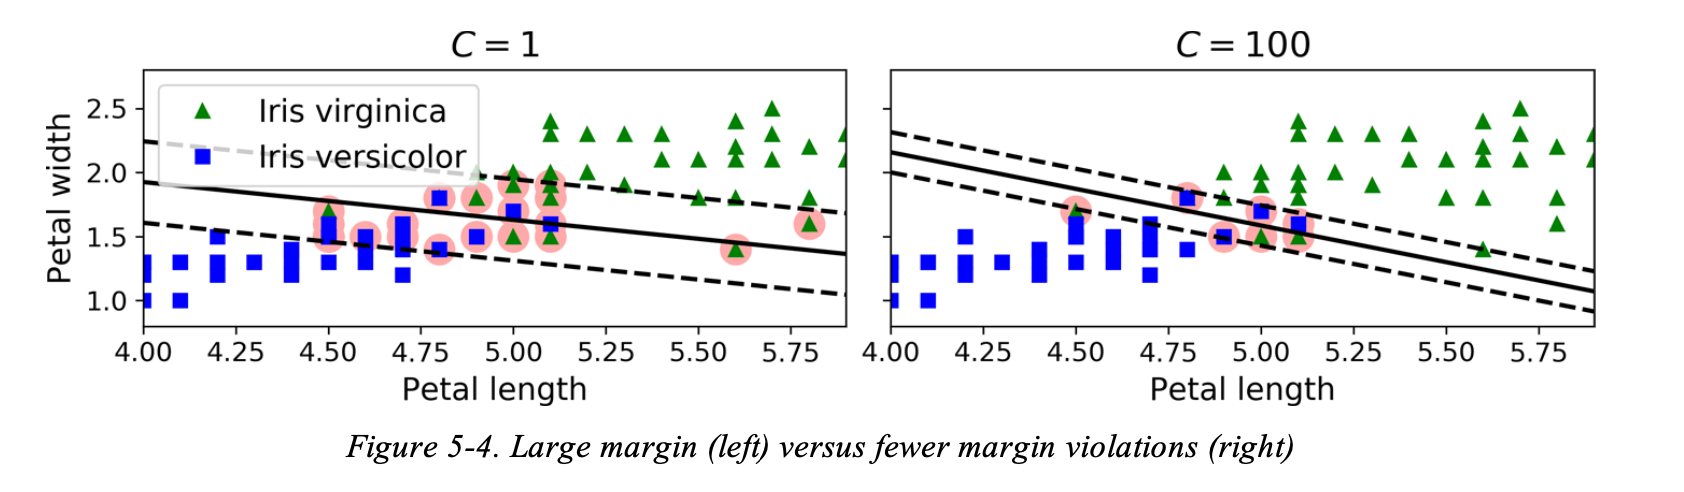

Notice that less margin violations is not always better. While the right model has less margin violations, the left model would probably generalize better to new data.

>One drawback of SVM classifiers is that they do not output probabilities for each class, only the class ID itself.

The `LinearSVC` class in `sklearn.svm` allows us to create a linear support vector machine classifier. We can also use the `SVC` class with a linear kernel (`SVC(kernel='linear', C=1)`). We can also use the `SGDClassifier(loss='hinge', alpha=1/(m*C))`. This last model will apply stochastic gradient descent to train a linear SVM classifier. It will not converge as fast as `LinearSVC`, but it is useful for online classification or huge datasets that do not fit in memory.

## Nonlinear SVM Classification

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. 

Sometimes we can add more features, such as polynomial features to a nonlinear dataset, resulting in a linearly separable dataset:

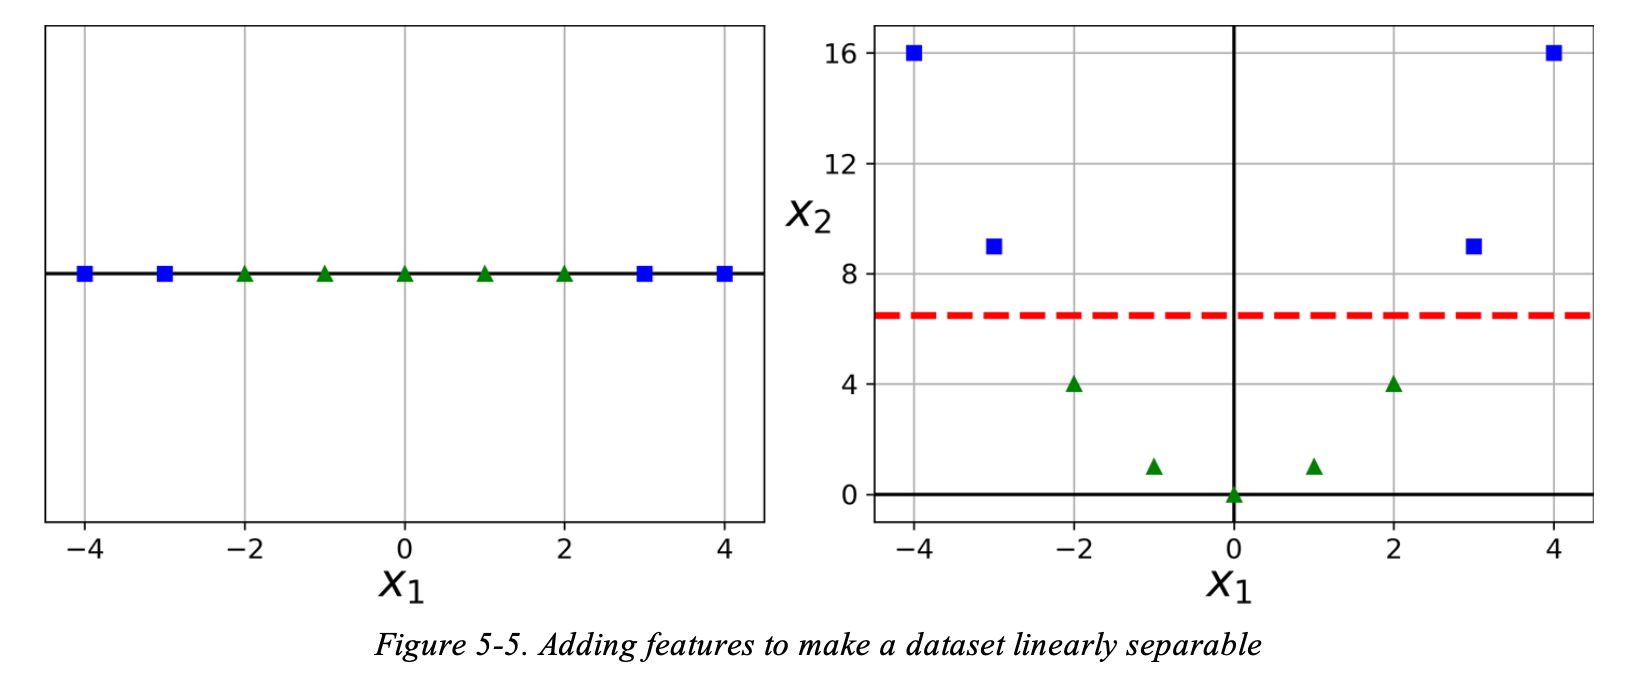

### Polynomial Kernel

Adding polynomial features is simple to implement and can work great. However, a low polynomial degree won't be able to deal with complex datasets, and a high polynomial degree will create a huge number of features, making the model slower (recall `PolynomialFeatures` will output every possible combination of the features up to the specified degree).

The *kernel trick* makes it possible to get the same result as if we had added many polynomial features without actually having to add them. There is no combinatorial blowup of the number of features because we don't actually add them. This trick is implemented by the `SVC` class: `SVC(kernel='poly', degree=3, coef0=1, C=5)`.

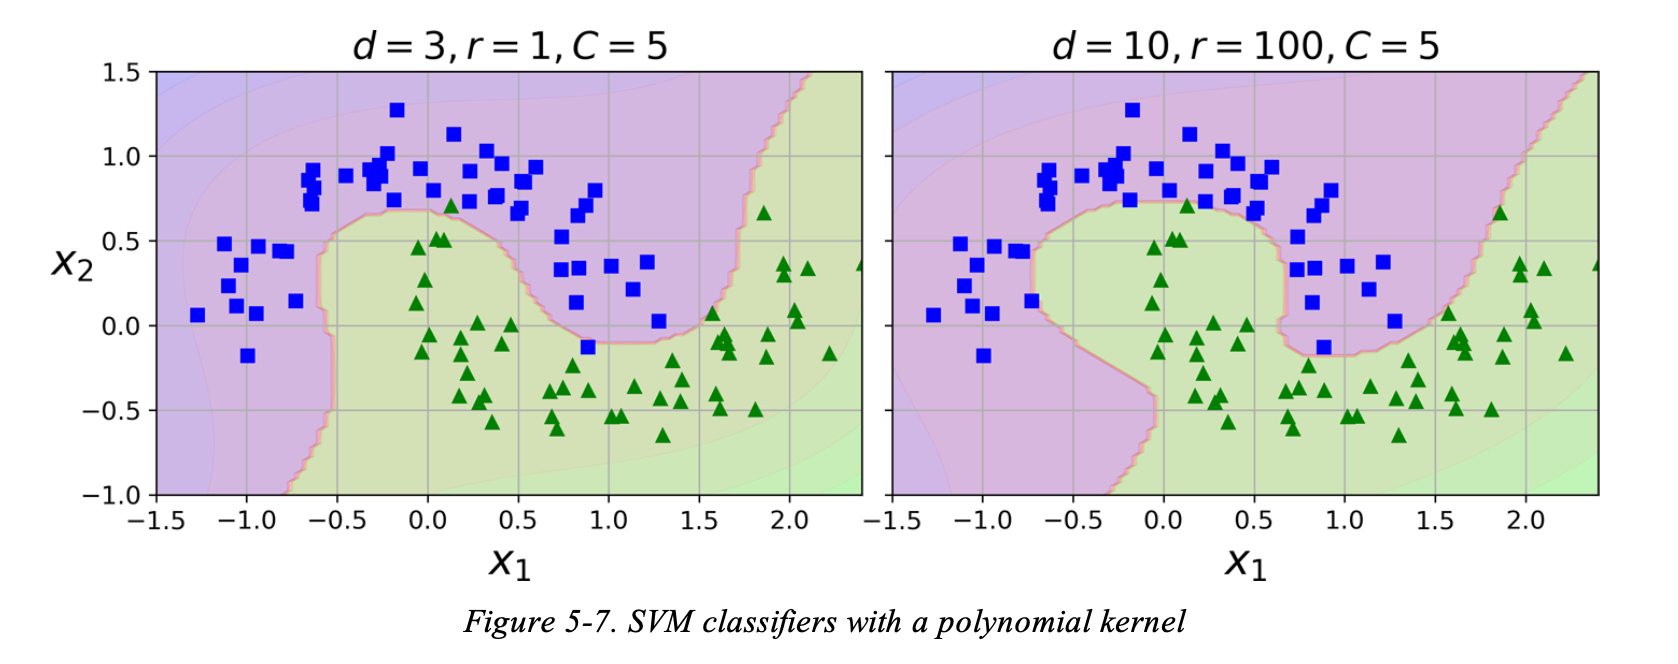

In the code in the previous paragraph, the `coef0` hyperparameter controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

### Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a *similarity function*, which measures how much each instance resembles a particular *landmark*. Consider the 1D dataset in the figure above about adding polynomial features to make a dataset linearly separable, and add two landmarks to it at $x_1 = -2$ and $x_1 = 1$. We define the similarity function to be the Gaussian *Radial Basis Function* (RBF) with $\gamma=0.3$.

> *Gaussian RBF*: $\phi_{\gamma}(\mathbf{x}, \ell)=\exp\big(-\gamma ||\mathbf{x}-\ell||^2\big)$

The dotted bell-shaped curves in the left plot below represent the Gaussian RBF.

The function varies from 0 (very far away from the landmark) to 1 (at the landmark). Now we use it to compute new features. For example: $x_1=-1$ is located a distance of 1 from the first landmark and 2 from the second mark. Therefore, its new features are $x_2=\exp(-0.3\times 1^2)\approx0.74$ and $x_3=\exp(-0.3\times 2^2)\approx0.30$. The right plot below shows the transformed dataset with the original features dropped:

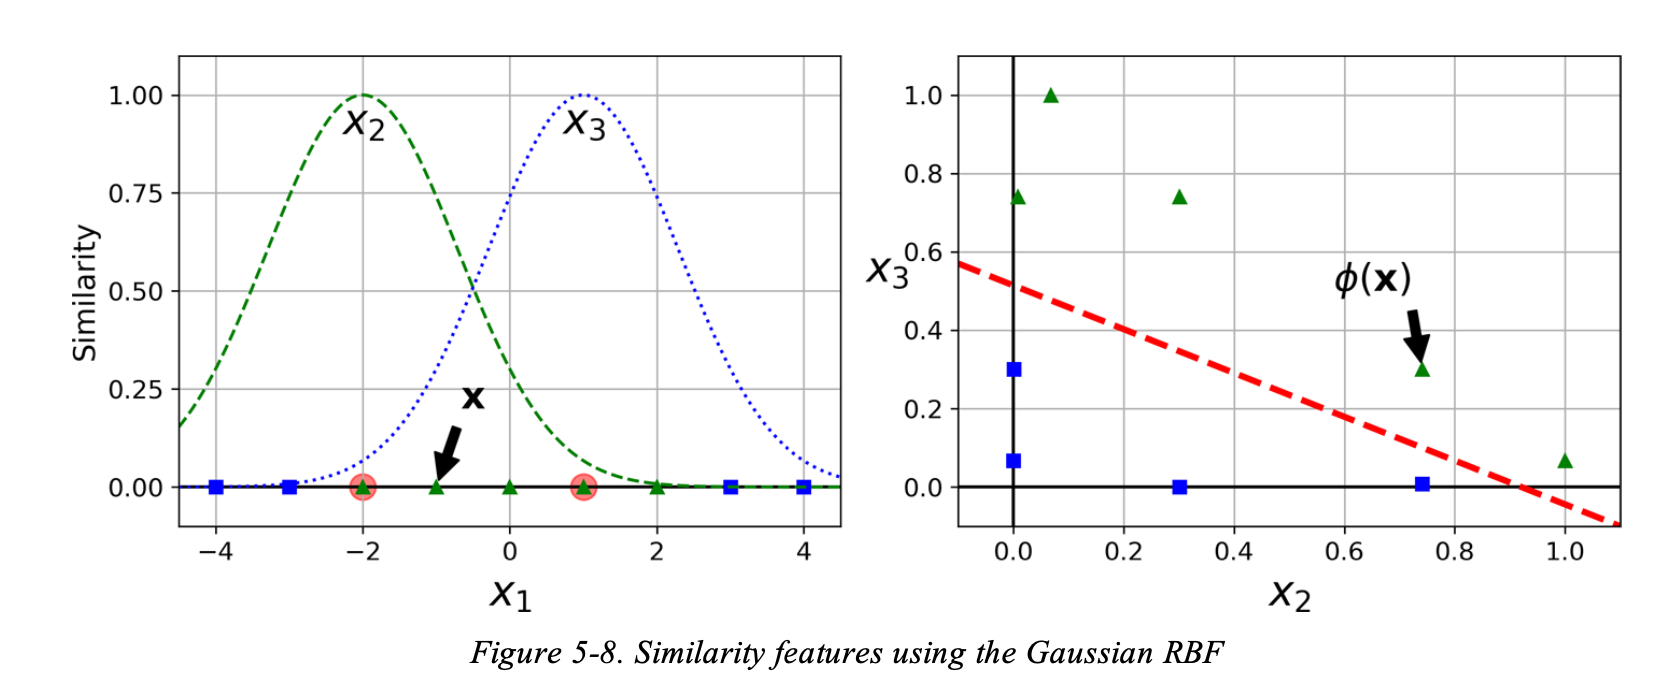

We can see on the right plot that the dataset is now linearly separable.

To select the landmarks, the easiest thing to do is just use every data instance as a landmark. Doing that creates many dimensions and increases the chances we get a linearly separable dataset output. However, the downside to that is that a training set with *m* instances and *n* features gets transformed into a training set with *m* instances and *m* features (if we drop the original features).

### Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be useful, but it may be computational expensive to compute all the additional features.

There is a kernel trick to use the Gaussian RBF similarity features with a support vector machine!

Once again, use the `SVC` class: `SVC(kernel='rbf', gamma=5, C=0.001)`.

An explanation of the hyperparameters:

    1. Increasing `gamma` makes the bell-shaped curve narrower, and hence more specific. Data points closer to a landmark are weighted greater than those farther away. A consequence of this is that the decision boundary ends up being more irregular, wiggling around individual instances.
    2. Decreasing `gamma` makes the bell-shaped curve wider, giving instances a larger range of influence. The decision boundary ends up smoother. 
    
The $\gamma$ hyperparameter thus acts like a regularization parameter. If the model is overfitting, we can try reducing it, and if we're underfitting we can try increasing $\gamma$.

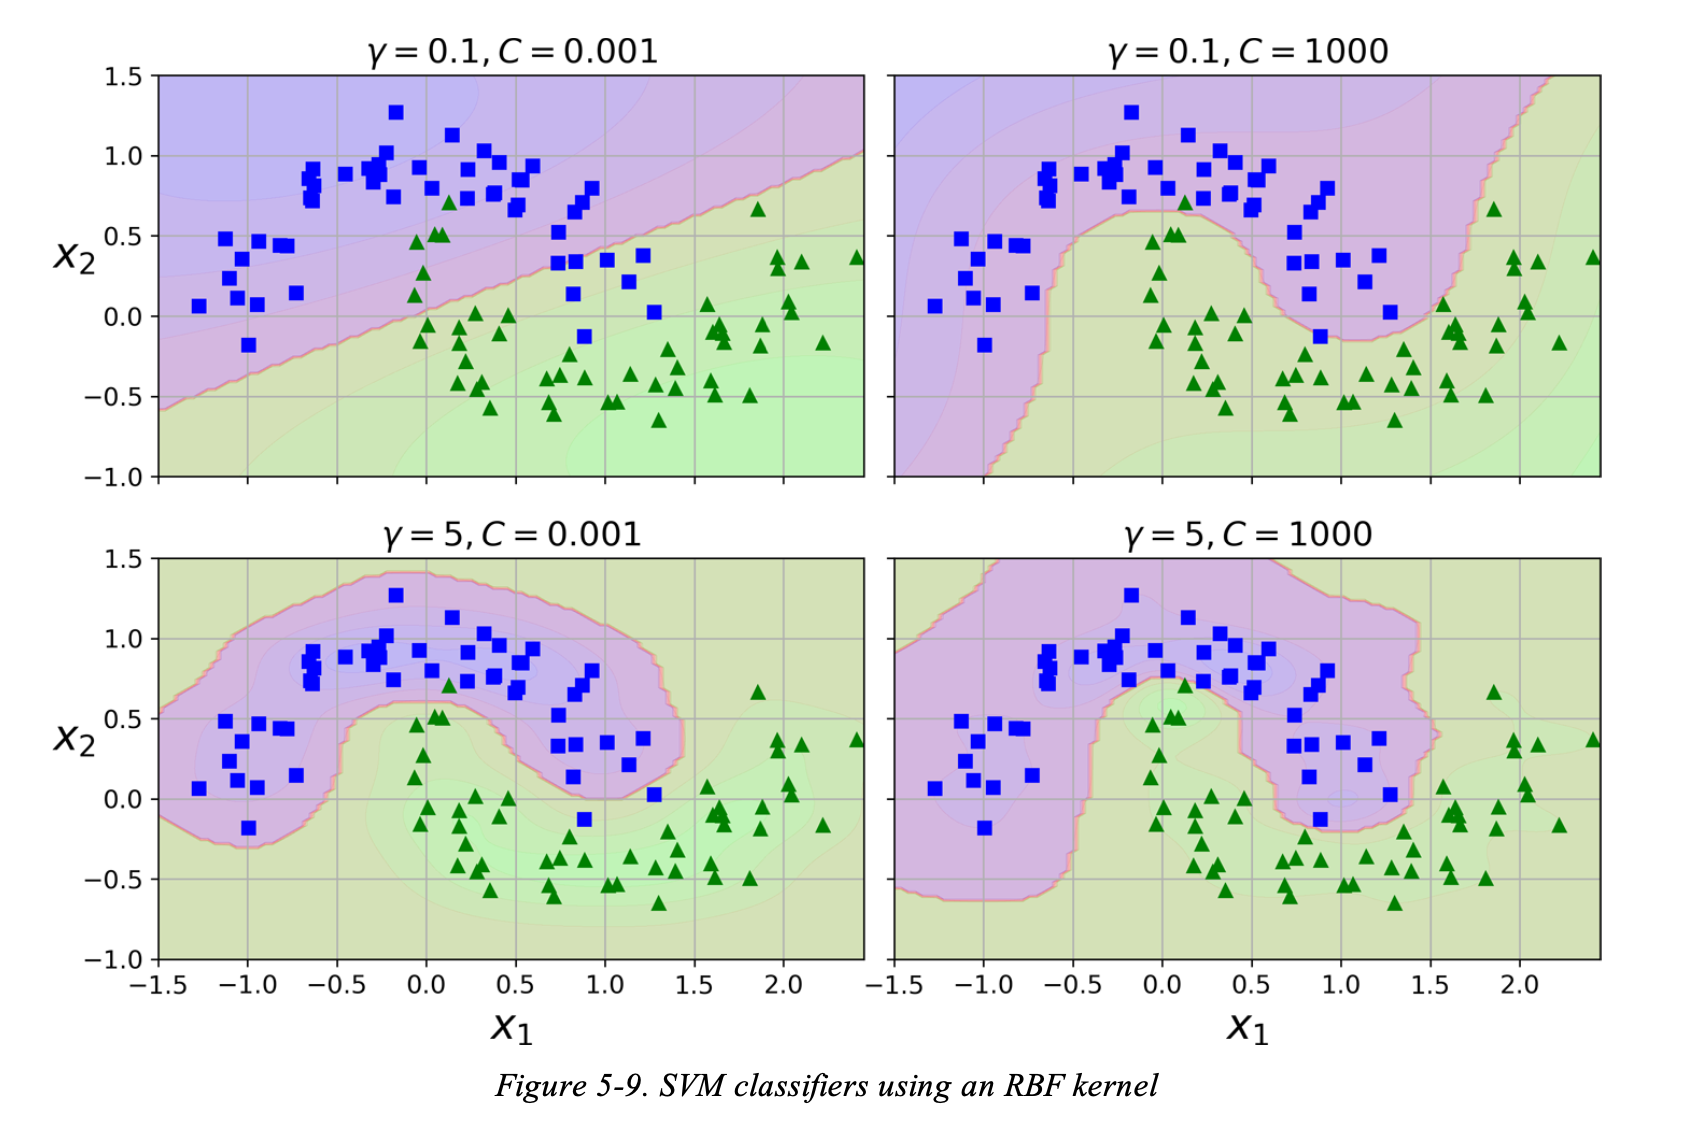

### Computational Complexity

The `LinearSVC` class is based on the `liblinear` library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features. Its training time complexity if roughly $O(m\times n)$.

The algorithm takes longer if we require high precision: the tolerance is controlled by the $\epsilon$ parameter.

The `SVC` class is based on the `libsvm` library, which supports the kernel trick. The training time complexity is usually between $O(m^2\times n)$ and $O(m^3\times n)$. It gets very slow when the number of training instances gets large. The algorithm is good for complex small- or medium-sized training sets and scales well with the number of features, especially *sparse* features. It scales roughly with the average number of nonzero features per instance.

| Class | Time Complexity | Out-of-core Support | Scaling Required | Kernel Trick
| :---: | :---: | :---: | :---: | :---: |
| `LinearSVC` | $O(m\times n)$ | No | Yes | No
| `SGDClassifier` | $O(m\times n)$ | Yes | Yes | No
| `SVC` | $O(m^2\times n)$ to $O(m^3\times n)$ | No | Yes | Yes

## SVM Regression

To perform regression instead of classification with an SVM, the trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, regression will try to fit as many instances as possible on the street while limiting margin violations. The width of the street is controlled by the $\epsilon$ hyperparameter.

Adding more training instances within the margin does not affect the model's predictions. The model is thus said to be *$\epsilon$-insensitive*. 

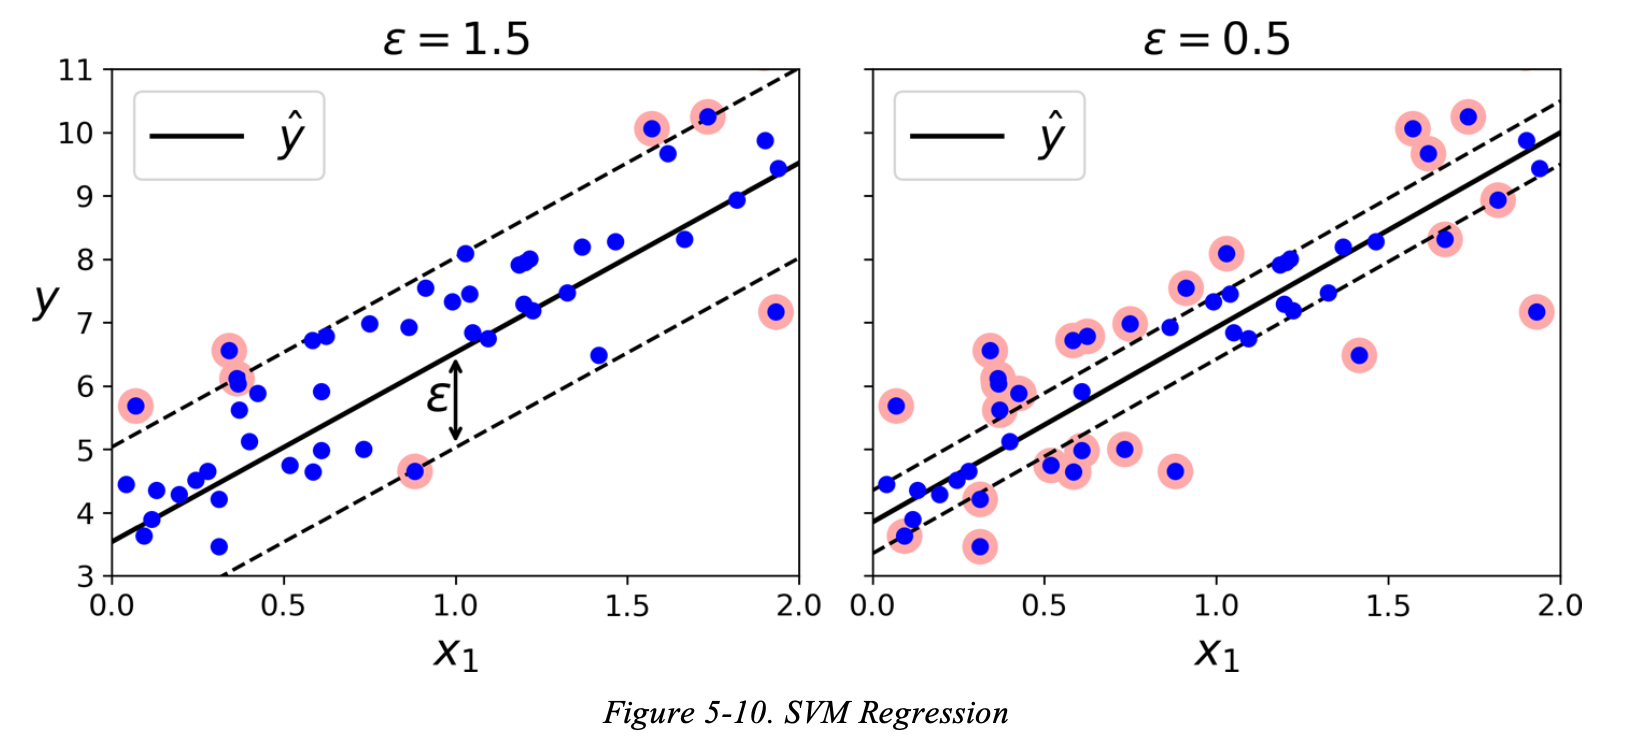

To perform linear SVM regression use the `LinearSVR` class, e.g. `LinearSVR(epsilon=1.5)`. For nonlinear regression tasks, we can use a kernelized SVM model, e.g. `SVR(kernel='poly', degree=2, C=100, epsilon=0.1)`.

# Exercises

1. What is the fundamental idea behind Support Vector Machines?
> The fundamental idea behind support vector machines is fitting the widest possible street between each class.

2. What is a support vector?
> A support vector is a data instance that determines the edges of the margins used to separate classes. They define the decision boundary of the support vector machine. Computing predictions only involves using the support vectors, not the entire training set.

3. Why is it important to scale the inputs when using SVMs?
> Scaling the inputs is important when using SVMs because they are trained using large margins. With unscaled data, the margins between classes can be very small, making it harder for the SVM to train using the input data.
> Correction: We must scale the inputs because the SVM will tend to ignore smaller features.

4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?
> No, an SVM classifier only outputs the class to which it believes an instance belongs.
> Correction: An SVM classifier cannot output the probability of an instance belonging to a class. We can, however, output the distance between the test instance and the decision boundary, which can be used as a confidence score. 

5. Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?
> The dual form of the SVM problem is faster to solve than the primal one when the number of training instances is smaller than the number of features, so it would not be wise to use it on this training set. We should use the primal form.

6. Suppose you've trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease $\gamma$? What about `C`?
> If the model is underfitting the training set, we can increase both $\gamma$ and `C`.